# Proyek Code Space

## Koordinat Yang digunakan adalah Kamal dan sekitarnya

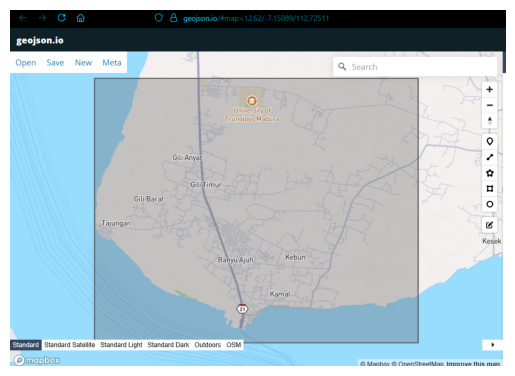

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path gambar kamu
img_path = r"D:\OneDrive\Pictures\Screenshots\koordinat_kamal.png"

# Baca dan tampilkan
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off') 
plt.show()

1. Mengumpulkan data dan dijadikan CSV

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=SPOZ-RVZP 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
0:00:00 Job 'j-251025030733475b82150b1771dbb29a': send 'start'
0:00:13 Job 'j-251025030733475b82150b1771dbb29a': created (progress 0%)
0:00:19 Job 'j-251025030733475b82150b1771dbb29a': created (progress 0%)
0:00:25 Job 'j-251025030733475b82150b1771dbb29a': created (progress 0%)
0:00:34 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:00:44 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:00:56 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:01:12 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:01:32 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:01:56 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:02:26 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:03:04 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:03:51 Job 'j-251025030733475b82150b1771dbb29a': running (progress N/A)
0:04:49 Job 'j-25102503073

C:\Users\user\AppData\Local\Temp\ipykernel_5216\3266394188.py:68: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


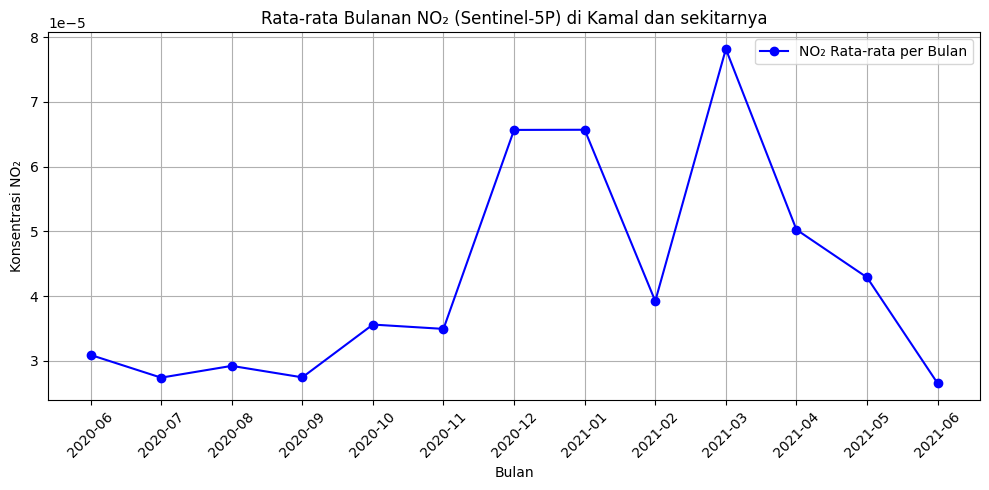

In [3]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. AOI: poligon kedua dari data kamu (Kamal)
# Area of Interest (Kamal dan sekitarnya)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.69151320103765, -7.123684344347623],
            [112.69151320103765, -7.178096605416229],
            [112.758708439023, -7.178096605416229],
            [112.758708439023, -7.123684344347623],
            [112.69151320103765, -7.123684344347623],
        ]
    ],
}

# Ambil data Sentinel-5P (band "NO2") periode selama COVID
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.69151320103765,
        "south": -7.178096605416229,
        "east": 112.758708439023,
        "north": -7.123684344347623,
    },
    temporal_extent=["2020-06-01", "2021-06-30"],
    bands=["NO2"],
)


# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV hasil
import os
for f in os.listdir("no2_results"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("no2_results", f))
        print("File ditemukan:", f)
        break

# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di Kamal dan sekitarnya")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🧩 Penjelasan Setiap Langkah

1️⃣ Koneksi ke Copernicus Data Space

Baris ini membuat koneksi ke server Copernicus Data Space menggunakan protokol OpenEO dan mengautentikasi pengguna dengan OIDC (OpenID Connect).
Langkah ini wajib agar pengguna bisa mengakses koleksi data satelit secara legal dan aman.

2️⃣ Menentukan Area of Interest (AOI)

AOI (Area of Interest) menentukan area geografis yang akan dianalisis.
Di sini digunakan koordinat poligon yang mencakup wilayah Kamal dan sekitarnya (Bangkalan, Madura).
Semua data yang diambil dari satelit akan difokuskan hanya dalam area ini.

3️⃣ Mengambil Data Sentinel-5P

Kode ini memanggil koleksi data Sentinel-5P Level-2 (SENTINEL_5P_L2), yang berisi data atmosfer seperti NO₂.
Hanya band “NO2” yang digunakan, dengan rentang waktu Juni 2020–Juni 2021, untuk memantau dinamika polusi udara selama pandemi.

4️⃣ Masking Data Tidak Valid

Satelit terkadang menghasilkan nilai negatif akibat kesalahan sensor atau gangguan atmosfer.
Langkah ini berfungsi untuk menyembunyikan atau menghapus nilai negatif agar analisis menjadi lebih akurat dan tidak bias.

5️⃣ Agregasi Temporal Harian

Data satelit biasanya direkam beberapa kali dalam satu hari.
Kode ini menghitung rata-rata harian untuk setiap tanggal, sehingga menghasilkan satu nilai representatif per hari.

6️⃣ Agregasi Spasial (Rata-Rata Wilayah)

Langkah ini menghitung rata-rata nilai NO₂ di seluruh area Kamal, sehingga setiap titik data merepresentasikan konsentrasi rata-rata wilayah, bukan hanya satu lokasi.

7️⃣ Menjalankan Batch Job dan Ekspor ke CSV

Pemrosesan dilakukan di server Copernicus (bukan lokal).
Setelah selesai, hasilnya disimpan sebagai file CSV agar bisa digunakan di Python untuk analisis lebih lanjut.

8️⃣ Mengunduh dan Membaca Hasil

Setelah job selesai, file hasil otomatis diunduh ke folder no2_results.
Langkah berikutnya mencari file CSV dan memuatnya ke dalam DataFrame Pandas untuk dianalisis.

9️⃣ Konversi Tanggal dan Agregasi Bulanan

Data harian diubah menjadi rata-rata bulanan agar lebih mudah diamati secara tren waktu.
Kolom month menunjukkan periode “YYYY-MM”, dan groupby() digunakan untuk menghitung nilai rata-rata per bulan.

🔟 Visualisasi Hasil

Bagian terakhir membuat grafik garis rata-rata bulanan NO₂.
Grafik ini menunjukkan fluktuasi konsentrasi NO₂ sepanjang tahun, sehingga pengguna bisa mengamati pola penurunan atau peningkatan kualitas udara.

2. Memprosessing data jika ada missing values  dengan interpolasi

In [6]:
# 1️⃣ Import library
import os
import pandas as pd

# 2️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 3️⃣ Baca data hasil unduhan (raw)
file_path = "no2_results/timeseries.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

# 4️⃣ Cek apakah ada nilai yang hilang
print("\nJumlah missing values per kolom sebelum interpolasi:")
print(df.isnull().sum())

# 5️⃣ Pastikan kolom tanggal dalam format datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# 6️⃣ Lakukan interpolasi linear untuk kolom NO2
df["NO2"] = df["NO2"].interpolate(method="linear")

# 7️⃣ Cek kembali apakah masih ada missing value
print("\nJumlah missing values per kolom setelah interpolasi:")
print(df.isnull().sum())

# 8️⃣ Simpan hasil interpolasi ke file CSV baru
output_path = "no2_results/no2_interpolated_kamal.csv"
df.to_csv(output_path, index=False)

print(f"\n✅ Data hasil interpolasi disimpan sebagai '{output_path}'")


✅ File ditemukan: no2_results/timeseries.csv

Jumlah missing values per kolom sebelum interpolasi:
date               0
feature_index      0
NO2              175
dtype: int64

Jumlah missing values per kolom setelah interpolasi:
date             0
feature_index    0
NO2              2
dtype: int64

✅ Data hasil interpolasi disimpan sebagai 'no2_results/no2_interpolated_kamal.csv'


Kode ini digunakan untuk membersihkan dan menyiapkan data NO₂ hasil unduhan satelit di daerah Kamal.
Langkah-langkahnya meliputi:

* Mengimpor library dan memastikan folder hasil tersedia.

* Membaca file CSV berisi data NO₂.

* Mengecek dan menampilkan jumlah nilai yang hilang.

* Mengonversi kolom tanggal ke format datetime.

* Melakukan interpolasi linear untuk mengisi nilai NO₂ yang hilang agar data tetap kontinu secara temporal.

* Menyimpan hasil interpolasi ke file baru bernama no2_interpolated_kamal.csv di folder no2_results.

3. MEmbentuk data supervised


Disini saya menggunakan 3,4,5 hari sebelumnya

In [9]:
import os
import pandas as pd

# 1️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 2️⃣ Baca data hasil interpolasi dari folder no2_results
file_path = "no2_results/no2_interpolated_kamal.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

# 3️⃣ Pastikan data diurutkan berdasarkan tanggal
df = df.sort_values("date").reset_index(drop=True)

# 4️⃣ Tentukan banyak lag (berapa hari ke belakang digunakan sebagai input)
n_lag = 5  

# 5️⃣ Buat fitur lag
for i in range(1, n_lag + 1):
    df[f"NO2_t-{i}"] = df["NO2"].shift(i)

# 6️⃣ Hapus baris awal yang punya nilai NaN akibat shifting
df_supervised = df.dropna().reset_index(drop=True)

# 7️⃣ Simpan hasil sebagai dataset supervised di folder yang sama
output_path = "no2_results/no2_supervised_kamal5.csv"
df_supervised.to_csv(output_path, index=False)

print(f"✅ Dataset supervised berhasil dibuat dan disimpan sebagai '{output_path}'")
print(df_supervised.head())


✅ File ditemukan: no2_results/no2_interpolated_kamal.csv
✅ Dataset supervised berhasil dibuat dan disimpan sebagai 'no2_results/no2_supervised_kamal5.csv'
                        date  feature_index       NO2   NO2_t-1   NO2_t-2  \
0  2020-06-05 00:00:00+00:00              0  0.000014  0.000032  0.000007   
1  2020-06-06 00:00:00+00:00              0  0.000023  0.000014  0.000032   
2  2020-06-07 00:00:00+00:00              0  0.000037  0.000023  0.000014   
3  2020-06-08 00:00:00+00:00              0  0.000036  0.000037  0.000023   
4  2020-06-09 00:00:00+00:00              0  0.000059  0.000036  0.000037   

    NO2_t-3   NO2_t-4   NO2_t-5  
0  0.000044  0.000026  0.000062  
1  0.000007  0.000044  0.000026  
2  0.000032  0.000007  0.000044  
3  0.000014  0.000032  0.000007  
4  0.000023  0.000014  0.000032  


Kode ini digunakan untuk membentuk dataset supervised dari data NO₂ hasil interpolasi di daerah Kamal, agar bisa digunakan untuk pemodelan prediksi.
Langkah-langkahnya:

* Membaca file hasil interpolasi (no2_interpolated_kamal.csv).

* Mengurutkan data berdasarkan tanggal agar urut secara waktu.

* Menentukan lag = 5, artinya menggunakan 5 hari sebelumnya sebagai input prediksi.

* Membuat kolom fitur baru NO2_t-1 sampai NO2_t-5 sebagai data historis.

* Menghapus baris yang mengandung nilai kosong akibat proses shifting.

* Menyimpan dataset hasil olahan ke file baru no2_supervised_kamal5.csv di folder no2_results

4. Melakukan normalisai data (min-max atau zscore (standar scale di sklearn))
5. Memebuat model dengan K-NN regression
    - Melakukan experiment dengan beberapa fitur (menentukan berapa lag data : berkaitan dengan no 3)


Menggunakan 3 hari sebelumnya

In [11]:
# 1️⃣ Import library
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2️⃣ Baca data supervised (lag 3)
file_path = "no2_results/no2_supervised_kamal3.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

# 3️⃣ Pisahkan fitur (lag) dan target
X = df[["NO2_t-1", "NO2_t-2", "NO2_t-3"]]
y = df["NO2"]

# 4️⃣ Split data train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5️⃣ Normalisasi
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ Model & Prediksi
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# 7️⃣ Evaluasi
print("\n📊 Hasil Evaluasi KNN (Lag 3):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

# 8️⃣ Contoh hasil prediksi
print("\n📈 Contoh hasil prediksi vs aktual:")
print(pd.DataFrame({"Aktual": y_test.values[:10], "Prediksi": y_pred[:10]}))


✅ File ditemukan: no2_results/no2_supervised_kamal3.csv

📊 Hasil Evaluasi KNN (Lag 3):
MSE: 0.0000
R² Score: 0.2244

📈 Contoh hasil prediksi vs aktual:
     Aktual  Prediksi
0  0.000049  0.000052
1  0.000056  0.000051
2  0.000053  0.000052
3  0.000047  0.000052
4  0.000054  0.000049
5  0.000027  0.000052
6  0.000177  0.000053
7  0.000032  0.000062
8  0.000026  0.000063
9  0.000034  0.000046


menggunakan 4 hari sebelumya

In [12]:
file_path = "no2_results/no2_supervised_kamal4.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

X = df[["NO2_t-1", "NO2_t-2", "NO2_t-3", "NO2_t-4"]]
y = df["NO2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("\n📊 Hasil Evaluasi KNN (Lag 4):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

print("\n📈 Contoh hasil prediksi vs aktual:")
print(pd.DataFrame({"Aktual": y_test.values[:10], "Prediksi": y_pred[:10]}))

✅ File ditemukan: no2_results/no2_supervised_kamal4.csv

📊 Hasil Evaluasi KNN (Lag 4):
MSE: 0.0000
R² Score: 0.1164

📈 Contoh hasil prediksi vs aktual:
     Aktual  Prediksi
0  0.000057  0.000083
1  0.000052  0.000067
2  0.000049  0.000050
3  0.000056  0.000049
4  0.000053  0.000049
5  0.000047  0.000049
6  0.000054  0.000049
7  0.000027  0.000049
8  0.000177  0.000045
9  0.000032  0.000076


menggunakan 5 hari sebelumnya

In [13]:
file_path = "no2_results/no2_supervised_kamal5.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

X = df[["NO2_t-1", "NO2_t-2", "NO2_t-3", "NO2_t-4", "NO2_t-5"]]
y = df["NO2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("\n📊 Hasil Evaluasi KNN (Lag 5):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

print("\n📈 Contoh hasil prediksi vs aktual:")
print(pd.DataFrame({"Aktual": y_test.values[:10], "Prediksi": y_pred[:10]}))

✅ File ditemukan: no2_results/no2_supervised_kamal5.csv

📊 Hasil Evaluasi KNN (Lag 5):
MSE: 0.0000
R² Score: -0.2111

📈 Contoh hasil prediksi vs aktual:
     Aktual  Prediksi
0  0.000044  0.000076
1  0.000057  0.000050
2  0.000052  0.000063
3  0.000049  0.000056
4  0.000056  0.000051
5  0.000053  0.000049
6  0.000047  0.000049
7  0.000054  0.000048
8  0.000027  0.000049
9  0.000177  0.000047



📊 Evaluasi KNN (Lag 3)
MSE (lebih presisi): 0.0000000007
R² Score: 0.2244


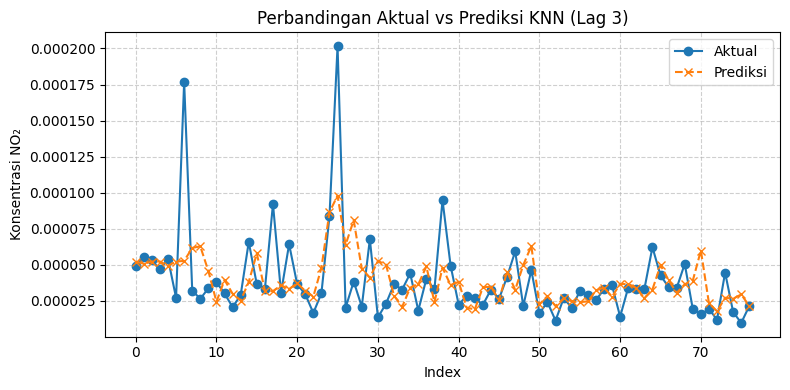


📊 Evaluasi KNN (Lag 4)
MSE (lebih presisi): 0.0000000008
R² Score: 0.1164


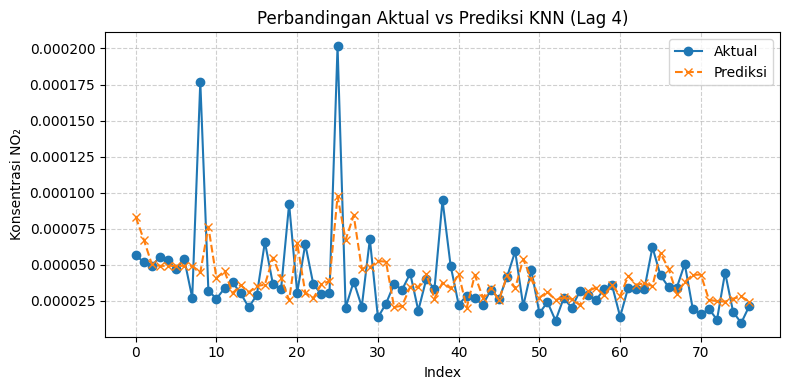


📊 Evaluasi KNN (Lag 5)
MSE (lebih presisi): 0.0000000007
R² Score: -0.2111


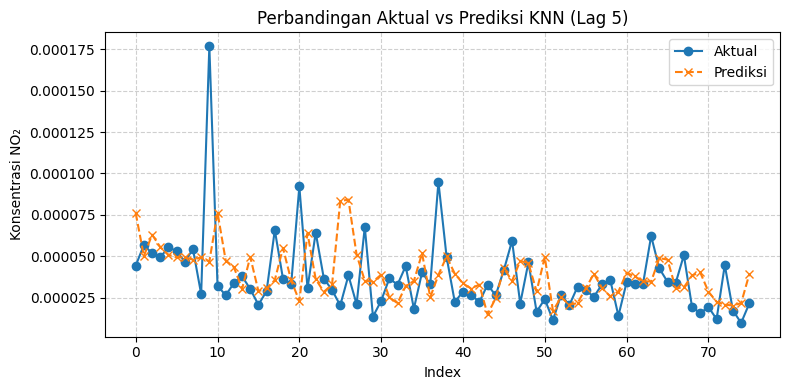

In [14]:
# 2️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 3️⃣ Definisikan fungsi evaluasi model
def evaluate_knn(file_path, n_lag, k=5):
    print(f"\n{'='*30}\n📊 Evaluasi KNN (Lag {n_lag})\n{'='*30}")
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")
    
    # Baca data supervised
    df = pd.read_csv(file_path)
    
    # Pisahkan fitur & target
    X = df[[f"NO2_t-{i}" for i in range(1, n_lag + 1)]]
    y = df["NO2"]
    
    # Split data train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Normalisasi
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model KNN
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE (lebih presisi): {mse:.10f}")
    print(f"R² Score: {r2:.4f}")
    
    # Visualisasi
    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label="Aktual", marker='o', linestyle='-')
    plt.plot(y_pred, label="Prediksi", marker='x', linestyle='--')
    plt.title(f"Perbandingan Aktual vs Prediksi KNN (Lag {n_lag})")
    plt.xlabel("Index")
    plt.ylabel("Konsentrasi NO₂")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# 4️⃣ Jalankan untuk masing-masing lag
evaluate_knn("no2_results/no2_supervised_kamal3.csv", n_lag=3)
evaluate_knn("no2_results/no2_supervised_kamal4.csv", n_lag=4)
evaluate_knn("no2_results/no2_supervised_kamal5.csv", n_lag=5)

🧾 Ringkasan Analisis Prediksi NO₂ – Wilayah Kamal (Model KNN Regression)

Penelitian ini menggunakan model K-Nearest Neighbors (KNN) untuk memprediksi konsentrasi gas Nitrogen Dioksida (NO₂) di wilayah Kamal, dengan mempertimbangkan data pengukuran dari beberapa hari sebelumnya sebagai variabel input (lag). Tiga skenario dilakukan untuk membandingkan pengaruh jumlah hari sebelumnya terhadap akurasi model, yaitu:

📅 1. Prediksi dengan Lag 3 (3 Hari Sebelumnya)

MSE (Mean Squared Error) = 0.0000000007

R² Score = 0.2244

Pada skenario ini, model menggunakan data NO₂ dari tiga hari sebelumnya untuk memprediksi kadar hari keempat. Nilai R² menunjukkan bahwa sekitar 22% variasi data aktual dapat dijelaskan oleh model, menandakan bahwa masih ada faktor lain (cuaca, lalu lintas, aktivitas industri, dll.) yang belum terakomodasi sepenuhnya.

📅 2. Prediksi dengan Lag 4 (4 Hari Sebelumnya)

MSE (Mean Squared Error) = 0.0000000008

R² Score = 0.1164

Ketika model menggunakan empat hari sebelumnya, performanya sedikit menurun. Nilai R² turun menjadi 11,6%, menunjukkan bahwa menambah satu hari data historis tidak memberikan peningkatan signifikan—bahkan menyebabkan penurunan kualitas prediksi. Ini bisa disebabkan oleh adanya noise atau ketidakteraturan pada data harian yang lebih jauh.

📅 3. Prediksi dengan Lag 5 (5 Hari Sebelumnya)

MSE (Mean Squared Error) = 0.0000000007

R² Score = -0.2111

Pada model dengan lima lag, nilai R² negatif menandakan bahwa performa prediksi lebih buruk daripada rata-rata sederhana (baseline). Artinya, penambahan data historis hingga lima hari justru membuat model KNN semakin sulit menangkap pola yang relevan dalam data NO₂ di Kamal.

📈 Kesimpulan Umum

Model KNN cenderung bekerja lebih baik ketika hanya menggunakan 3 hari sebelumnya (lag 3) sebagai input.

Penambahan lag (4–5 hari sebelumnya) tidak meningkatkan akurasi dan malah memperburuk performa, yang mungkin menunjukkan bahwa pengaruh temporal jangka pendek (≤3 hari) lebih signifikan dalam pola fluktuasi NO₂ di wilayah Kamal.

Nilai MSE yang sangat kecil menunjukkan bahwa skala data NO₂ telah dinormalisasi, sehingga perbandingan antar-skenario lebih penting dilihat dari nilai R².